<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np
import seaborn as sns

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
print(response)
j_res = json.loads(response.text) # json文字列をdictへ
print(j_res.keys())
j_res['patients_summary']['data'][-15:]

<Response [200]>
dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])


[{'小計': 759, '日付': '2021-04-23T08:00:00.000Z'},
 {'小計': 876, '日付': '2021-04-24T08:00:00.000Z'},
 {'小計': 635, '日付': '2021-04-25T08:00:00.000Z'},
 {'小計': 425, '日付': '2021-04-26T08:00:00.000Z'},
 {'小計': 828, '日付': '2021-04-27T08:00:00.000Z'},
 {'小計': 925, '日付': '2021-04-28T08:00:00.000Z'},
 {'小計': 1027, '日付': '2021-04-29T08:00:00.000Z'},
 {'小計': 698, '日付': '2021-04-30T08:00:00.000Z'},
 {'小計': 1050, '日付': '2021-05-01T08:00:00.000Z'},
 {'小計': 879, '日付': '2021-05-02T08:00:00.000Z'},
 {'小計': 708, '日付': '2021-05-03T08:00:00.000Z'},
 {'小計': 609, '日付': '2021-05-04T08:00:00.000Z'},
 {'小計': 621, '日付': '2021-05-05T08:00:00.000Z'},
 {'小計': 591, '日付': '2021-05-06T08:00:00.000Z'},
 {'小計': 907, '日付': '2021-05-07T08:00:00.000Z'}]

In [4]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [5]:
keys = ['contacts', 'querents', 'patients_summary']

In [6]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2021-05-03 17:00:00+09:00,672,0,708,2021-05-03 17:00:00+09:00
2021-05-04 17:00:00+09:00,682,0,609,2021-05-04 17:00:00+09:00
2021-05-05 17:00:00+09:00,736,0,621,2021-05-05 17:00:00+09:00
2021-05-06 17:00:00+09:00,1077,0,591,2021-05-06 17:00:00+09:00


In [7]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2021-05-03 17:00:00+09:00,672,0,708,2021-05-03 17:00:00+09:00,662.000000,4634.0,0.0,0.0,873.571429,6115.0
2021-05-04 17:00:00+09:00,682,0,609,2021-05-04 17:00:00+09:00,664.571429,4652.0,0.0,0.0,842.285714,5896.0
2021-05-05 17:00:00+09:00,736,0,621,2021-05-05 17:00:00+09:00,678.285714,4748.0,0.0,0.0,798.857143,5592.0
2021-05-06 17:00:00+09:00,1077,0,591,2021-05-06 17:00:00+09:00,746.428571,5225.0,0.0,0.0,736.571429,5156.0
2021-05-07 17:00:00+09:00,0,0,907,2021-05-07 17:00:00+09:00,650.428571,4553.0,0.0,0.0,766.428571,5365.0


In [8]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2021-04-23 17:00:00+09:00,550,0,759,2021-04-23 17:00:00+09:00,484.285714,3390.0,0.0,0.0,697.285714,4881.0,'21w16,Fri
2021-04-24 17:00:00+09:00,681,0,876,2021-04-24 17:00:00+09:00,514.428571,3601.0,0.0,0.0,714.000000,4998.0,'21w16,Sat
2021-04-25 17:00:00+09:00,492,0,635,2021-04-25 17:00:00+09:00,527.857143,3695.0,0.0,0.0,727.142857,5090.0,'21w16,Sun
2021-04-26 17:00:00+09:00,611,0,425,2021-04-26 17:00:00+09:00,550.142857,3851.0,0.0,0.0,730.000000,5110.0,'21w17,Mon
2021-04-27 17:00:00+09:00,664,0,828,2021-04-27 17:00:00+09:00,581.142857,4068.0,0.0,0.0,746.714286,5227.0,'21w17,Tue
2021-04-28 17:00:00+09:00,640,0,925,2021-04-28 17:00:00+09:00,593.857143,4157.0,0.0,0.0,758.428571,5309.0,'21w17,Wed
2021-04-29 17:00:00+09:00,600,0,1027,2021-04-29 17:00:00+09:00,605.428571,4238.0,0.0,0.0,782.142857,5475.0,'21w17,Thu
2021-04-30 17:00:00+09:00,672,0,698,2021-04-30 17:00:00+09:00,622.857143,4360.0,0.0,0.0,773.428571,5414.0,'21w17,Fri
2021-05-01 17:00:00+09:00,733,0,1050,2021-05-01 17:00:00+09:00,630.285714,4412.0,0.0,0.0,798.285714,5588.0,'21w17,Sat
2021-05-02 17:00:00+09:00,653,0,879,2021-05-02 17:00:00+09:00,653.285714,4573.0,0.0,0.0,833.142857,5832.0,'21w17,Sun


In [9]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [10]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2021-04-18 17:00:00+09:00,586.428571,4105
2021-04-25 17:00:00+09:00,727.142857,5090
2021-05-02 17:00:00+09:00,833.142857,5832
2021-05-07 17:00:00+09:00,687.200000,3436
2021-01-03 17:00:00+09:00,816.000000,2448


In [11]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2021-04-23 17:00:00+09:00,550,0,759,2021-04-23 17:00:00+09:00,484.285714,3390.0,0.0,0.0,697.285714,4881.0,'21w16,Fri,NaN,NaN
2021-04-24 17:00:00+09:00,681,0,876,2021-04-24 17:00:00+09:00,514.428571,3601.0,0.0,0.0,714.000000,4998.0,'21w16,Sat,NaN,NaN
2021-04-25 17:00:00+09:00,492,0,635,2021-04-25 17:00:00+09:00,527.857143,3695.0,0.0,0.0,727.142857,5090.0,'21w16,Sun,727.142857,5090.0
2021-04-26 17:00:00+09:00,611,0,425,2021-04-26 17:00:00+09:00,550.142857,3851.0,0.0,0.0,730.000000,5110.0,'21w17,Mon,NaN,NaN
2021-04-27 17:00:00+09:00,664,0,828,2021-04-27 17:00:00+09:00,581.142857,4068.0,0.0,0.0,746.714286,5227.0,'21w17,Tue,NaN,NaN
2021-04-28 17:00:00+09:00,640,0,925,2021-04-28 17:00:00+09:00,593.857143,4157.0,0.0,0.0,758.428571,5309.0,'21w17,Wed,NaN,NaN
2021-04-29 17:00:00+09:00,600,0,1027,2021-04-29 17:00:00+09:00,605.428571,4238.0,0.0,0.0,782.142857,5475.0,'21w17,Thu,NaN,NaN
2021-04-30 17:00:00+09:00,672,0,698,2021-04-30 17:00:00+09:00,622.857143,4360.0,0.0,0.0,773.428571,5414.0,'21w17,Fri,NaN,NaN
2021-05-01 17:00:00+09:00,733,0,1050,2021-05-01 17:00:00+09:00,630.285714,4412.0,0.0,0.0,798.285714,5588.0,'21w17,Sat,NaN,NaN
2021-05-02 17:00:00+09:00,653,0,879,2021-05-02 17:00:00+09:00,653.285714,4573.0,0.0,0.0,833.142857,5832.0,'21w17,Sun,833.142857,5832.0


### グラフ出力

In [12]:
sns.set()
sns.set_style('whitegrid')

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
# y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
# y2_1 = df3['patients_7d_mov_sum']
# y2_2 = df3['patients_week_sum']

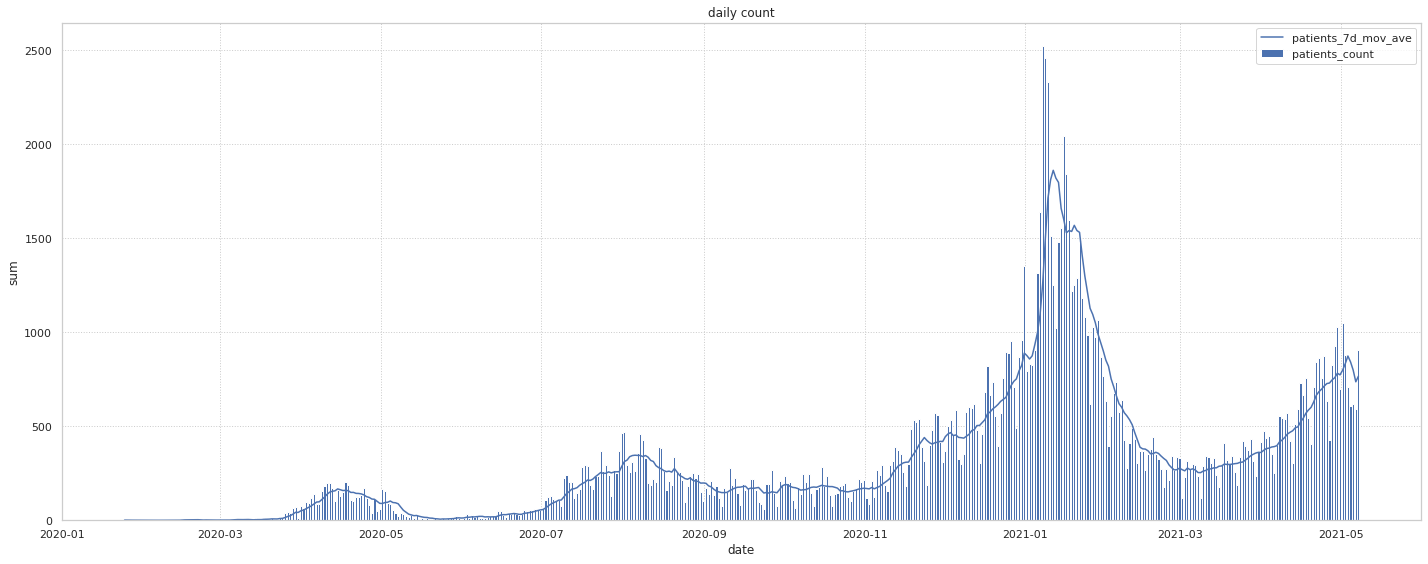

In [15]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

### 日毎の数
ax.set_title('daily count')
ax.set_xlabel('date')
ax.set_ylabel('sum')
ax.bar(x, y1_1, label='patients_count')
ax.plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
# ax[0].bar(x, y1_4, label='patients_week_mean')
ax.grid(linestyle=':')
ax.legend()

# ### 週毎の合計
# ax[1].set_title('weekly count')
# ax[1].set_xlabel('date')
# ax[1].set_ylabel('sum')
# ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
# ax[1].bar(x, y2_2, label='patients_week_sum')
# ax[1].grid(linestyle=':')
# ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
455,1.619165e+09,2021,4,23,1,0,0,0,0,0,0,455,0,381,550,484.285714,3390.0,0,0.0,0.0,759,697.285714,4881.0
456,1.619251e+09,2021,4,24,0,0,1,0,0,0,0,456,0,382,681,514.428571,3601.0,0,0.0,0.0,876,714.000000,4998.0
457,1.619338e+09,2021,4,25,0,0,0,1,0,0,0,457,0,383,492,527.857143,3695.0,0,0.0,0.0,635,727.142857,5090.0
458,1.619424e+09,2021,4,26,0,1,0,0,0,0,0,458,0,384,611,550.142857,3851.0,0,0.0,0.0,425,730.000000,5110.0
459,1.619510e+09,2021,4,27,0,0,0,0,0,1,0,459,0,385,664,581.142857,4068.0,0,0.0,0.0,828,746.714286,5227.0
460,1.619597e+09,2021,4,28,0,0,0,0,0,0,1,460,0,386,640,593.857143,4157.0,0,0.0,0.0,925,758.428571,5309.0
461,1.619683e+09,2021,4,29,0,0,0,0,1,0,0,461,0,387,600,605.428571,4238.0,0,0.0,0.0,1027,782.142857,5475.0
462,1.619770e+09,2021,4,30,1,0,0,0,0,0,0,462,0,388,672,622.857143,4360.0,0,0.0,0.0,698,773.428571,5414.0
463,1.619856e+09,2021,5,1,0,0,1,0,0,0,0,463,0,389,733,630.285714,4412.0,0,0.0,0.0,1050,798.285714,5588.0
464,1.619942e+09,2021,5,2,0,0,0,1,0,0,0,464,0,390,653,653.285714,4573.0,0,0.0,0.0,879,833.142857,5832.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470 entries, 0 to 469
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            470 non-null    float64
 1   year                 470 non-null    int64  
 2   month                470 non-null    int64  
 3   day                  470 non-null    int64  
 4   Fri                  470 non-null    uint8  
 5   Mon                  470 non-null    uint8  
 6   Sat                  470 non-null    uint8  
 7   Sun                  470 non-null    uint8  
 8   Thu                  470 non-null    uint8  
 9   Tue                  470 non-null    uint8  
 10  Wed                  470 non-null    uint8  
 11  passed               470 non-null    int64  
 12  emergency            470 non-null    int64  
 13  em_passed            470 non-null    int64  
 14  contacts_count       470 non-null    int64  
 15  contacts_7d_mov_ave  470 non-null    flo

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,4.700000e+02,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000
mean,1.600114e+09,2020.270213,5.736170,15.706383,0.144681,0.142553,0.142553,0.142553,0.142553,0.142553,0.142553,234.500000,0.104255,166.404255,678.317021,674.557700,4721.895745,784.082979,784.082979,5488.580851,307.321277,302.766049,2119.327660
std,1.173498e+07,0.444543,3.417403,8.901197,0.352154,0.349989,0.349989,0.349989,0.349989,0.349989,0.349989,135.821574,0.305917,127.355363,447.463497,434.826926,3043.801095,876.894486,781.698053,5471.886370,370.429482,349.398092,2445.816709
min,1.579853e+09,2020.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.589983e+09,2020.000000,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,117.250000,0.000000,43.250000,382.250000,387.071429,2709.500000,0.000000,0.000000,0.000000,54.000000,50.785714,355.500000
50%,1.600114e+09,2020.000000,5.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.500000,0.000000,160.500000,544.500000,557.571429,3903.000000,396.500000,896.071429,6272.500000,200.000000,183.285714,1283.000000
75%,1.610244e+09,2021.000000,9.000000,23.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,351.750000,0.000000,277.750000,794.750000,806.464286,5645.250000,1396.250000,1392.642857,9748.500000,396.250000,389.357143,2725.500000
max,1.620374e+09,2021.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,469.000000,1.000000,395.000000,2265.000000,2096.857143,14678.000000,4060.000000,2574.142857,18019.000000,2520.000000,1861.142857,13028.000000


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,0.769153,0.105168,-0.011379,5.766256e-18,-0.001503,-0.007513,-0.004508,0.007513,0.001503,0.004508,1.000000e+00,-0.343229,0.994587,-0.275676,-0.264282,-0.264276,-0.496814,-0.535114,-0.535114,0.617914,0.651710,0.651726
year,7.691529e-01,1.000000,-0.552275,-0.055884,8.519830e-03,-0.001429,-0.001429,-0.001429,-0.001429,-0.001429,-0.001429,7.691529e-01,-0.207593,0.792044,-0.261301,-0.243195,-0.243192,-0.544668,-0.610999,-0.610999,0.583952,0.637317,0.637318
month,1.051681e-01,-0.552275,1.000000,-0.013206,-1.427943e-02,0.001206,-0.007707,-0.004142,0.011902,0.004772,0.008337,1.051681e-01,-0.122519,0.062150,0.049988,0.036607,0.036610,0.201919,0.256830,0.256830,-0.105900,-0.145877,-0.145855
day,-1.137901e-02,-0.055884,-0.013206,1.000000,1.154051e-02,-0.010491,0.000460,0.005251,0.001829,-0.006384,-0.002278,-1.137901e-02,-0.000480,-0.010328,-0.009287,-0.010196,-0.010199,0.012757,-0.002264,-0.002264,-0.007039,-0.000748,-0.000764
Fri,5.766256e-18,0.008520,-0.014279,0.011541,1.000000e+00,-0.167697,-0.167697,-0.167697,-0.167697,-0.167697,-0.167697,-2.533999e-18,-0.001769,0.001308,-0.027192,-0.004536,-0.004535,0.033035,-0.005206,-0.005206,0.050623,0.000818,0.000809
Mon,-1.502618e-03,-0.001429,0.001206,-0.010491,-1.676974e-01,1.000000,-0.166253,-0.166253,-0.166253,-0.166253,-0.166253,-1.502618e-03,0.000297,-0.001583,0.039017,-0.000107,-0.000106,0.150665,0.000873,0.000873,-0.121563,-0.000704,-0.000702
Sat,-7.513091e-03,-0.001429,-0.007707,0.000460,-1.676974e-01,-0.166253,1.000000,-0.166253,-0.166253,-0.166253,-0.166253,-7.513091e-03,0.000297,-0.006940,0.047254,-0.002759,-0.002758,-0.172238,0.000873,0.000873,0.056928,-0.004649,-0.004655
Sun,-4.507854e-03,-0.001429,-0.004142,0.005251,-1.676974e-01,-0.166253,-0.166253,1.000000,-0.166253,-0.166253,-0.166253,-4.507854e-03,0.000297,-0.004261,-0.018697,-0.001452,-0.001451,-0.158628,0.000873,0.000873,-0.038970,-0.002465,-0.002466
Thu,7.513091e-03,-0.001429,0.011902,0.001829,-1.676974e-01,-0.166253,-0.166253,-0.166253,1.000000,-0.166253,-0.166253,7.513091e-03,0.000297,0.006549,-0.004047,0.004887,0.004888,0.044508,0.000873,0.000873,0.079871,0.003828,0.003834
Tue,1.502618e-03,-0.001429,0.004772,-0.006384,-1.676974e-01,-0.166253,-0.166253,-0.166253,-0.166253,1.000000,-0.166253,1.502618e-03,0.000297,0.001096,-0.023462,0.001258,0.001259,0.060578,0.000873,0.000873,-0.036667,0.000811,0.000815


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465,1.620029e+09,0,1,0,0,0,0,0,465,0,391,672,0,708,873.571429,6115.0
466,1.620115e+09,0,0,0,0,0,1,0,466,0,392,682,0,609,842.285714,5896.0
467,1.620202e+09,0,0,0,0,0,0,1,467,0,393,736,0,621,798.857143,5592.0
468,1.620288e+09,0,0,0,0,1,0,0,468,0,394,1077,0,591,736.571429,5156.0


In [26]:
_df2 = _df[['timestamp', 'passed', 'emergency', 'patients_count', 'patients_7d_mov_ave', 'patients_7d_mov_sum']]
_df2

,timestamp,passed,emergency,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,0,0,1,1.000000,1.0
1,1.579939e+09,1,0,1,1.000000,2.0
2,1.580026e+09,2,0,0,0.666667,2.0
3,1.580112e+09,3,0,0,0.500000,2.0
4,1.580198e+09,4,0,0,0.400000,2.0
...,...,...,...,...,...,...
465,1.620029e+09,465,0,708,873.571429,6115.0
466,1.620115e+09,466,0,609,842.285714,5896.0
467,1.620202e+09,467,0,621,798.857143,5592.0
468,1.620288e+09,468,0,591,736.571429,5156.0


In [27]:
sns.set(style="ticks", color_codes=True)
#sns.pairplot(data=_df)

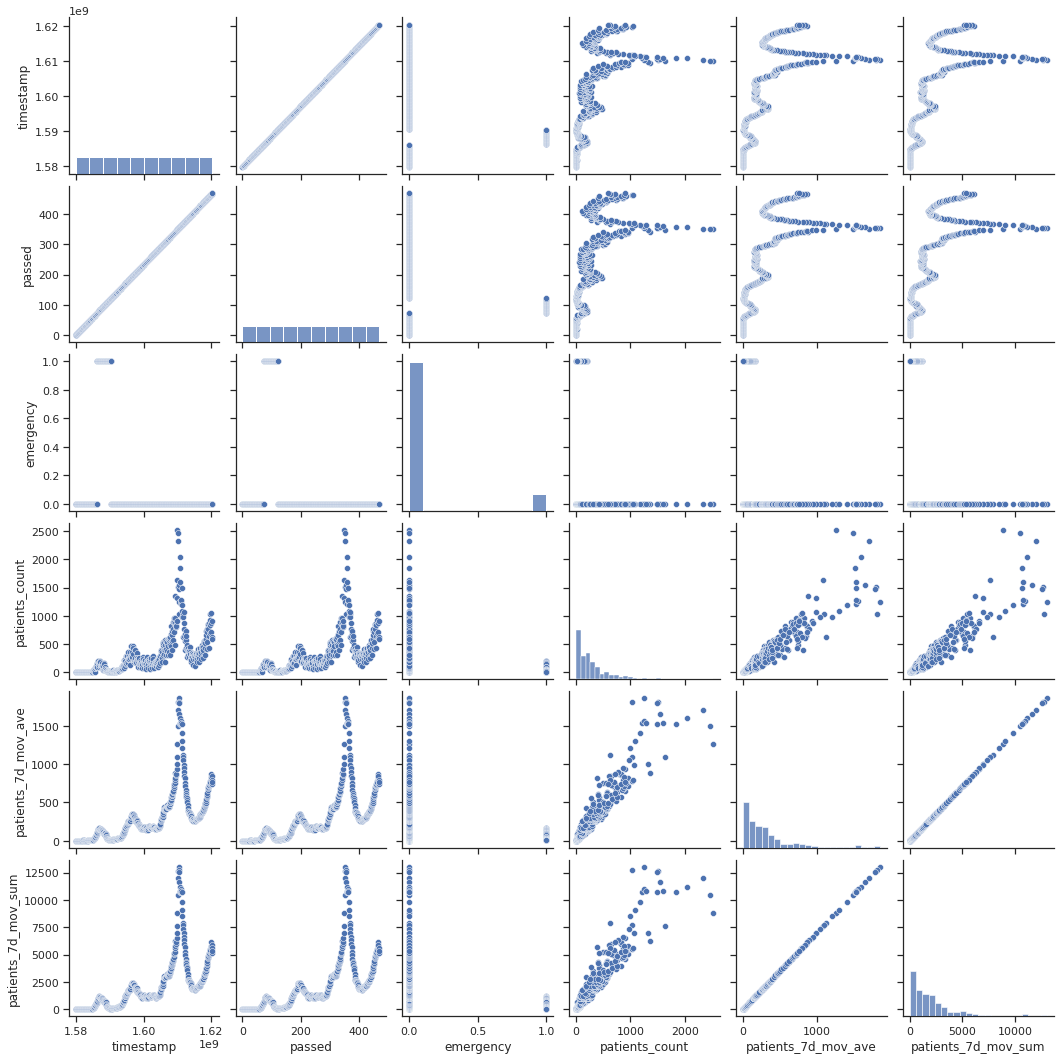

In [28]:
sns.pairplot(data=_df2)

In [29]:
!python -V

Python 3.7.10
